<h1><center>Modelling Notebook</center></h1>

ABSTRACT: The following notebook documents our group's modelling work. It includes 3 models that categorize the genre of a novel, each of which function with increasingly greater input data. Namely, model #1 utilizes the novel's title when generating a label, model #2 utilizes a novel's summary, and model #3 will utilize a concatenation of both. Furthermore, each model will use tfidf features, as we believe that it provides the most support for language-based models due to its use of relative frequency and weighting.

<h3>Modelling Prep</h3>

In [1]:
# Necessary installations
!pip install matplotlib
!pip install seaborn
!pip install mplcyberpunk
!pip install scikit-learn
!pip install pickle

import pandas as pd
import regex as re
import numpy as np
import logging

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

# ML Modeling
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn.preprocessing import normalize

# Saving and importing trained models
import pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [2]:
# Constructs a dataframe
df = pd.read_csv('../data/data.csv', delimiter=',', encoding='utf-8')

In [3]:
# Provides a quick overview of the shape and info of our dataframe (confirming that the data was successfully read & transferred)
df.shape

(4657, 4)

In [4]:
# Displays the title column for a quick evaluation
df.title

0                       Drowned Wednesday
1                           The Lost Hero
2               The Eyes of the Overworld
3                         Magic's Promise
4                          Taran Wanderer
                      ...                
4652                              Hounded
4653    Charlie and the Chocolate Factory
4654                           Red Rising
4655                            Frostbite
4656                             Radiance
Name: title, Length: 4657, dtype: object

In [5]:
# Processes the data for classification
#   - Namely, creates an additional column within the dataframe that combines the contents of the novel's title and summary,
#     which will be the predominant input for our model. Will also create multiple dataframes sorted by the length of each 
#     field to analyze the relationship between length and model accuracy. 

df['sum_title'] = df['summary'] + ' '+ df['title']

df['title_length'] = df.title.apply(len)
df['summary_length'] = df.summary.apply(len)
df['sum_title_length'] = df.sum_title.apply(len)

In [6]:
# Utilizes the provided training code from Notebook 5.1 

#Now we beging training our model
def _reciprocal_rank(true_genre_labels: list, machine_predicted_genre_labels: list):
  #determining recirprical rank at cutoff
#now wer creaate parameters
        # `true_genre_labels` (List): # List of the actual book genre labels
        # `machine_predicted_genre_labels` (List): # List of book genre labels predicted by the LR algorithm
    
    #The return value will be reciprical rank
    
 # add index to list ONLY if machine predicted label is true 
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_predicted_genre_labels) if r in true_genre_labels]

    recip_rank = 0
    if len(tp_pos_list) > 0:
        # finds fist corectly predicted item
        first_pos_list = tp_pos_list[0]
        
    
        recip_rank = 1 / float(first_pos_list)

    return recip_rank

def compute_mrr_at_k(eval_book_genre_items:list):
    
    ## creating a function that computes Mean reciprical rank

    rr_total = 0
    
    for item in eval_book_genre_items:
        actual_label = item[0]
        pred_label_list = item[1]

        # Finds the reciprocal rank  for this row
        rr_at_k = _reciprocal_rank(actual_label, pred_label_list)

        # Add the row's RR to  scores for the entire data
        rr_total = rr_total + rr_at_k

        # Updates the Mean Reciprocal Rank  score with new row value
        mean_reciprocal_rank_score = rr_total / 1/float(len(eval_book_genre_items))

    return mean_reciprocal_rank_score

def collect_preds(Y_test, Y_preds):
    ##This function will gather all predicted book genres and the true book genres 
    pred_gold_list = [ [ [Y_test[index]], pred ] for index, pred in enumerate(Y_preds) ]
    return pred_gold_list
             
def compute_accuracy(eval_book_genre_items:list):
    
    #this will compute the overall accuracy score our the model 
    correct_book_cat = 0
    
    for book_genre_cat in eval_book_genre_items:
        true_gen = book_genre_cat[0]
        machine_gen = set(book_genre_cat[1])
        
        for book_cat in true_gen:
            if book_cat in machine_gen:
                correct_book_cat += 1
                break
    
    book_cat_prediction_accuracy = correct_book_cat / float(len(eval_book_genre_items))
    return book_cat_prediction_accuracy


#---------------------------------------------------------------------------------------------------

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df, field, training_data, testing_data, type='tfdif'):
# this function will extract features using different method types: counts, binary, or TF-IDF

    logging.info("Extracting features and creating vocabulary...")
    
    if 'binary' in type:
        
        # Now we are creating a new CountVectorizer()
        cv = CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif 'counts' in type:
        
        cv = CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    elif 'tfidf':    
        
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model, X_test, k, threshold=False):
 # this will use our input to return the book genre with the top estimated probability of being accurate
    if threshold == False:
        probs = model.predict_proba(X_test)
        best_n = np.argsort(probs, axis=1)[:,-k:]
        preds = [[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
        preds = [ item[::-1] for item in preds]
    
        return preds
    else:
        # get probabilities instead of predicted labels
        probs = (model.predict_proba(X_test)[:,1] >= thresh_val)

        # top predictions by probability
        best_n = np.argsort(probs, axis=1)[:,-k:]
        
        # gets category of predictions
        preds = [[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
        
        preds = [ item[::-1] for item in preds]
    
        return preds
   
def train_model(df, field="summary", feature_rep="tfdif", top_k=3):
 # now we are creating the main control of the function

    y = df['genre']
    x_training_data,x_testing_data = train_test_split(
        df,
        random_state=2000  )

    # getting labels and category values from each split data
    Y_train = x_training_data['genre'].values
    Y_test = x_testing_data['genre'].values
     
    # Extracting features
    X_train,X_test,feature_transformer = extract_features(
        df,
        field,
        x_training_data,
        x_testing_data,
        type=feature_rep
    )

    # start classifier object
    logging.info("Training a Logistic Regression Model. This may take a few minutes. ...")
    scikit_log_reg = LogisticRegression(
        verbose=0, 
        solver='liblinear',
        random_state=0,
        C=5,
        penalty='l2',
        max_iter=1000
    )
    # Create the model
    model = scikit_log_reg.fit(X_train, Y_train)

    # top predictions
    preds = get_top_k_predictions(model, X_test, top_k)
    
    eval_items = collect_preds(Y_test, preds)
    
    # Evaluation on test dat
    logging.info("Starting evaluation...")
    simple_mean_avg_correct_prediction_accuracy = compute_accuracy(eval_items)
    mean_recip_rank_at_k = compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")

    # Return the computed model 
    return model,feature_transformer,simple_mean_avg_correct_prediction_accuracy,mean_recip_rank_at_k,X_train,X_test,Y_test,Y_train,preds,eval_items

In [7]:
# Combines the modelling and plotting process into a single function
def train_and_display(graph_title: str, df:pd.DataFrame, training_field: str, feature_rep='tfidf', top_k=3, colors="Purples"):

  # Trains the model based on the provided training field 
  model_st,transformer_st,accuracy_st,mrr_at_k_st,X_train,X_test,Y_test,Y_train,preds,eval_items = train_model(
  df,
  field=training_field,
  feature_rep=feature_rep,
  top_k=top_k
  )

  # Prints the overall mean average accuracy and mean reciprocal rank 
  print("")
  print(f"Overall Mean Average Model Accuracy = {accuracy_st}\nMean Reciprocal Rank = {mrr_at_k_st}")

  # Predicts the classes on the test data
  Y_predictions_st = model_st.predict(X_test)
  # Predicts the classes on the test data, and returns the probability for each class
  Y_probability_a_st = model_st.predict_proba(X_test)

  # Creates and saves a pie chart illustrating the distribution of correct predictions within the top 3
  num_predictions_required_label = [f"Not Predicted Within {top_k}", "1st Prediction", "2nd Prediction", "3 Prediction"]
  num_predictions_required = [0,0,0,0]
  for item in eval_items: 
    if (item[0][0]) not in item[1]:
      num_predictions_required[0] += 1
    elif (item[0][0]) == item[1][0]:
      num_predictions_required[1] += 1
    elif (item[0][0]) == item[1][1]:
      num_predictions_required[2] += 1
    elif (item[0][0]) == item[1][2]:
      num_predictions_required[3] += 1
  plt.figure(figsize=(5,5))
  plt.pie(num_predictions_required, autopct='%1.2f%%')
  plt.title(f'Prediction Distribution for {graph_title}')
  plt.legend(num_predictions_required_label, loc="lower left")
  plt.savefig(f'../figures/prediction_distribution_{training_field}', bbox_inches='tight')
  plt.show()

  # Creates a confusion matrix using the predicted data and their probability 
  cm_ts = confusion_matrix(
  Y_test, 
  Y_predictions_st
  )

  # Normalizes matrix by columns
  cm_st_normed_by_column = normalize(cm_ts, axis=1, norm='l1')

  plt.figure(figsize=(25,10))

  # Creates a heat map using the normalized confusion matrix 
  sns.heatmap(
    cm_st_normed_by_column, #normalized confusion matrix
    annot=True, # add normalized counts of co-occurrences between actual vs. predicted
    fmt=".3f", # round to thousandths decimal place
    linewidths=1, # style choice for row/column lines
    square=True, # make the 
    cmap=colors,
    xticklabels=model_st.classes_,
    yticklabels=model_st.classes_,
  )

  # Axis labelling
  plt.ylabel('Actual Label of Novel Genre')
  plt.xlabel('Predicted Label of Novel Genre')

  # Graph labelling
  all_sample_title = f"{graph_title}\nOverall Accuracy Score: {accuracy_st}\nMean Reciprocal Rank: {mrr_at_k_st}"
  plt.title(
    all_sample_title,
    size=15
  )

  plt.tight_layout()
  mplcyberpunk.add_glow_effects()
  plt.savefig(f'../figures/confusion_matrix_{training_field}', bbox_inches='tight')
  plt.show()


def display_length_vs_accuracy(df:pd.DataFrame, training_field, feature_rep='tfidf', top_k=3):
  length = training_field + '_length'
  quartiles = df[length].quantile([0.25, 0.50, 0.75])
  df1 = pd.DataFrame(df[df[length] <= quartiles[0.25]])
  df2 = df[df[length].between(quartiles[0.25], quartiles[0.50], inclusive='right')]
  df3 = df[df[length].between(quartiles[0.50], quartiles[0.75], inclusive='right')]
  df4 = df[df[length] > quartiles[0.75]]

  model_st,transformer_st,accuracy_st,mrr_at_k_st,X_train,X_test,Y_test,Y_train,preds,eval_items = train_model(
    df1,
    field=training_field,
    feature_rep=feature_rep,
    top_k=top_k
    )

  quartile_dfs = [df1, df2, df3, df4]

  accuracy_points = []
  for quartile_df in quartile_dfs: 
    model_st,transformer_st,accuracy_st,mrr_at_k_st,X_train,X_test,Y_test,Y_train,preds,eval_items = train_model(
      quartile_df,
      field=training_field,
      feature_rep=feature_rep,
      top_k=top_k
      )
    accuracy_points.append(accuracy_st)
    
  plt.plot(['0-25%', '25-50%', '50-75%', '75-100%'], accuracy_points, marker='o', linestyle='-')
  plt.xlabel(f"Quartile of {training_field} length Used")
  plt.ylabel("Accuracy of Model")
  plt.title(f"Length of {training_field} vs Accuracy of Model")
  plt.savefig(f'../figures/length_of_{training_field}_vs_accuracy', bbox_inches='tight')
  plt.show()

  model_path = f"./../models/book_genre_model_{feature_rep}_{training_field}.pkl"
  transformer_path_td_only = f"./../models/book_genre_transformer_{feature_rep}_{training_field}.pkl"
  # Save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
  pickle.dump( model_st, open(model_path, 'wb') )
  pickle.dump( transformer_st, open(transformer_path_td_only,'wb') )

    

<h4>MODEL #1: Title only</h4>

2023-12-12 18:43:42,588 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:42,684 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:42,784 : INFO : Starting evaluation...
2023-12-12 18:43:42,786 : INFO : Done training and evaluation.



Overall Mean Average Model Accuracy = 0.671244635193133
Mean Reciprocal Rank = 0.49213161659513566


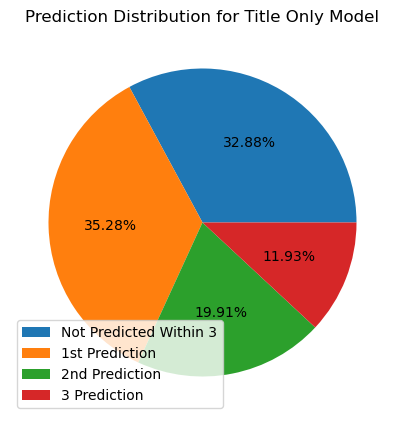

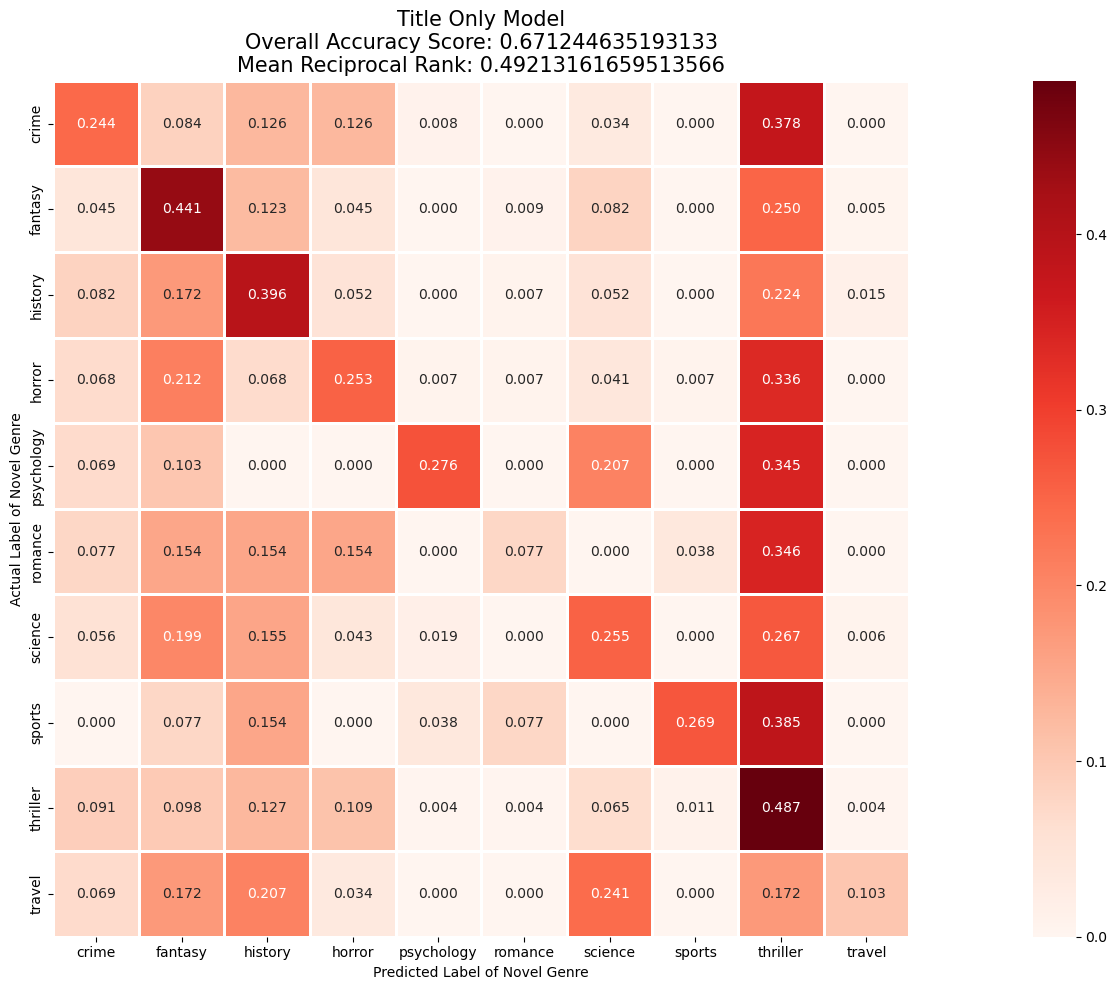

2023-12-12 18:43:43,911 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:43,936 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:43,944 : INFO : Starting evaluation...
2023-12-12 18:43:43,952 : INFO : Done training and evaluation.
2023-12-12 18:43:43,952 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:43,960 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:43,977 : INFO : Starting evaluation...
2023-12-12 18:43:43,977 : INFO : Done training and evaluation.
2023-12-12 18:43:43,977 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:43,993 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:44,001 : INFO : Starting evaluation...
2023-12-12 18:43:44,001 : INFO : Done training and evaluation.
2023-12-12 18:43:44,010 : INFO : Extracting features and creating vocabulary...
2023-12-12 

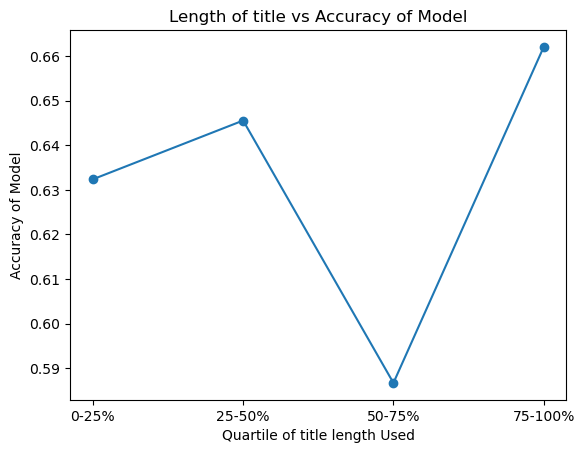

In [8]:
train_and_display('Title Only Model', df, 'title', colors='Reds')
display_length_vs_accuracy(df, 'title')

<h4>Model #1 Observations </h4>

(1) The model is moderately accurate with an overall accuracy of 0.671 and a MRR of 0.492.

(2) A diagonal pattern across the confusion graph is visually apparent - supporting the notion of the model's relative accuracy. 

(3) Regarding a breakdown of the MRR, the model was shown to correctly categorize a novel 35.28% of the time using its highest-scoring probability, 19.91% of the time using its second highest-scoring probability, and 11.93% of the time using its third highest-scoring probability. 

(4) The model seems to have a clear bias towards the genres of thriller, fantasy, and history - all of which occur within the top four most frequently occurring genres. Moreover, the confusion graph seems to indicate that the level of bias towards these genres are directly correlated with their specific distribution (for example, the model is more biased towards the most popular genre, thriller, compared to the second most popular genre, fantasy). Conversely, less frequent genres such as romance, crime, and travel possess noticeably weaker true positive rates. As a result, it would appear that our model would benefit from a more even genre distribution. 

(5) Based on 4 separately-trained variations of the model (using distinct subsets of the data), we analyzed how the model's accuracy fluctuated depending on the general/average length of its title entries. Specifically, we found that the model was generally more accurate with longer titles. However, we found a notable outlier which occurred when the model was trained using titles whose length fell within top 50-75% of all titles. In this variation, the accuracy dropped by roughly 4%. Currently, we don't have a good understanding of why this result occurred, however, it offers an opportunity to further explore our model and the capabilities and weaknesses of our current data.


<h4>MODEL #2: Summary Only</h4>

2023-12-12 18:43:44,328 : INFO : Extracting features and creating vocabulary...


2023-12-12 18:43:46,332 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:47,279 : INFO : Starting evaluation...
2023-12-12 18:43:47,279 : INFO : Done training and evaluation.



Overall Mean Average Model Accuracy = 0.8987124463519314
Mean Reciprocal Rank = 0.7742489270386274


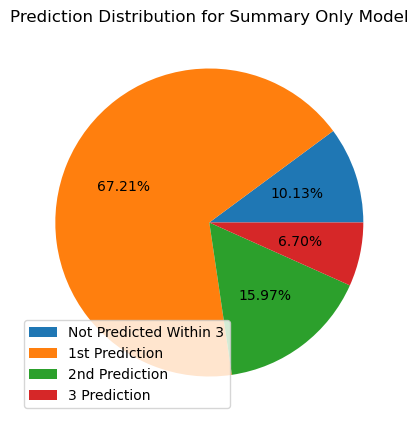

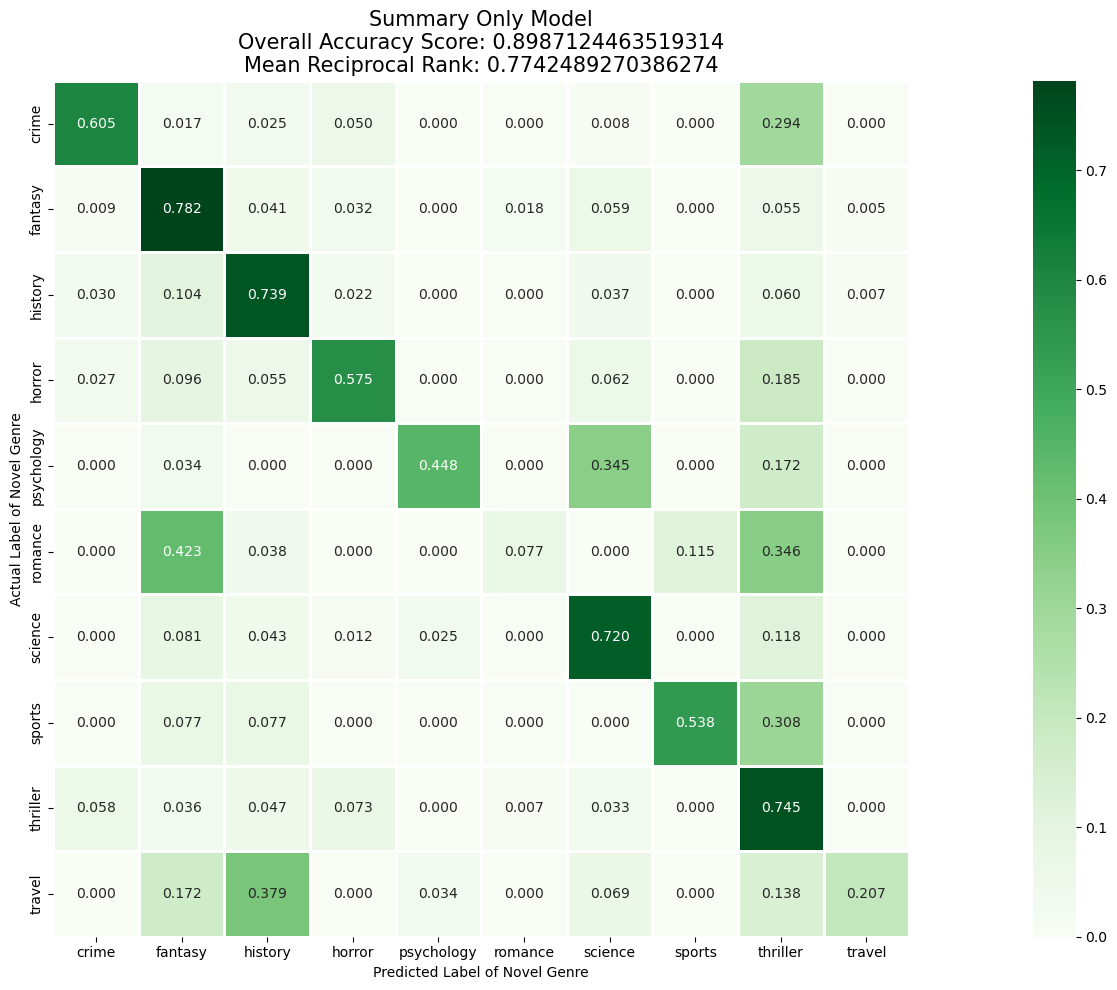

2023-12-12 18:43:48,489 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:48,620 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:48,693 : INFO : Starting evaluation...
2023-12-12 18:43:48,693 : INFO : Done training and evaluation.
2023-12-12 18:43:48,701 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:48,847 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:48,920 : INFO : Starting evaluation...
2023-12-12 18:43:48,920 : INFO : Done training and evaluation.
2023-12-12 18:43:48,928 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:49,196 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:49,309 : INFO : Starting evaluation...
2023-12-12 18:43:49,309 : INFO : Done training and evaluation.
2023-12-12 18:43:49,317 : INFO : Extracting features and creating vocabulary...
2023-12-12 

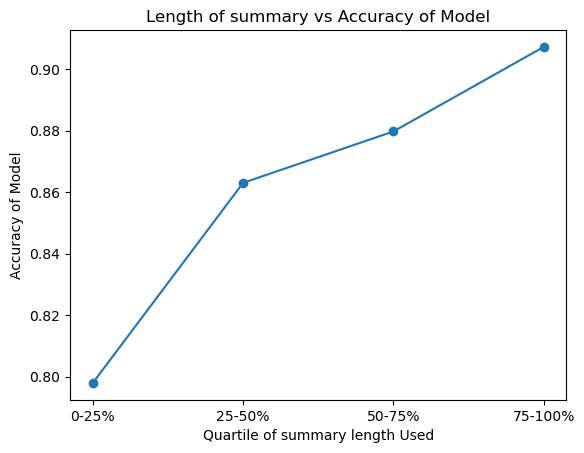

In [9]:
train_and_display('Summary Only Model', df, 'summary', colors='Greens')
display_length_vs_accuracy(df, 'summary')

<h4>Model #2 Observations</h4>

(1) The model is largely accurate with an overall accuracy of 0.898 and a MRR of 0.774. 

(2) A diagonal pattern across the confusion graph is visually apparent (moreso than model #1) - supporting the notion of the model's increased accuracy. 

(3) Regarding a breakdown of the MRR, the model was shown to correctly categorize a novel 67.21% of the time using its highest-scoring probability, 15.97% of the time using its second highest-scoring probability, and 6.7% of the time using its third highest-scoring probability. Based on these statistics, it appears that the overall accuracy didn't just increase, but that the greater accuracy of the model's "first" prediction predominantly drove this increase. 

(4) Compared to model #1, this model saw drastic improvement in terms of bias. Although there are still noticable trends towards specifc genres, the model is significantly more neutral. Interestingly, although confusion is generally less likely to occur in model #2, when it does occur, its rate is generally higher than its counterpart in model #1. For example, the rate of a travel novel being incorrectly labelled as a histroy text is 0.207 in model #1 compared to 0.379 in model #2. As such, the occurence of confusion in model #2 is more likely to be in "pockets" opposed to distributed in a pattern. 

(5) Based on 4 separately-trained variations of the model (using distinct subsets of the data), we analyzed how the model's accuracy fluctuated depending on the general/average length of its summary entries, finding that the accuracy consistently increased with longer summaries (however, a more comprehensive analysis would have to be conducted to confirm this as a general and not model-specific pattern).

<h4>Model #3: Title and Summary</h4>

2023-12-12 18:43:51,845 : INFO : Extracting features and creating vocabulary...


2023-12-12 18:43:53,930 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:54,846 : INFO : Starting evaluation...
2023-12-12 18:43:54,846 : INFO : Done training and evaluation.



Overall Mean Average Model Accuracy = 0.903862660944206
Mean Reciprocal Rank = 0.7799713876967105


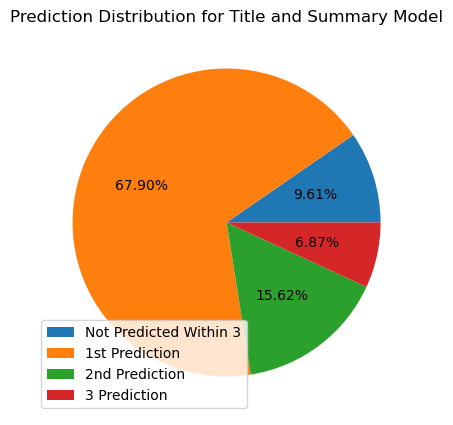

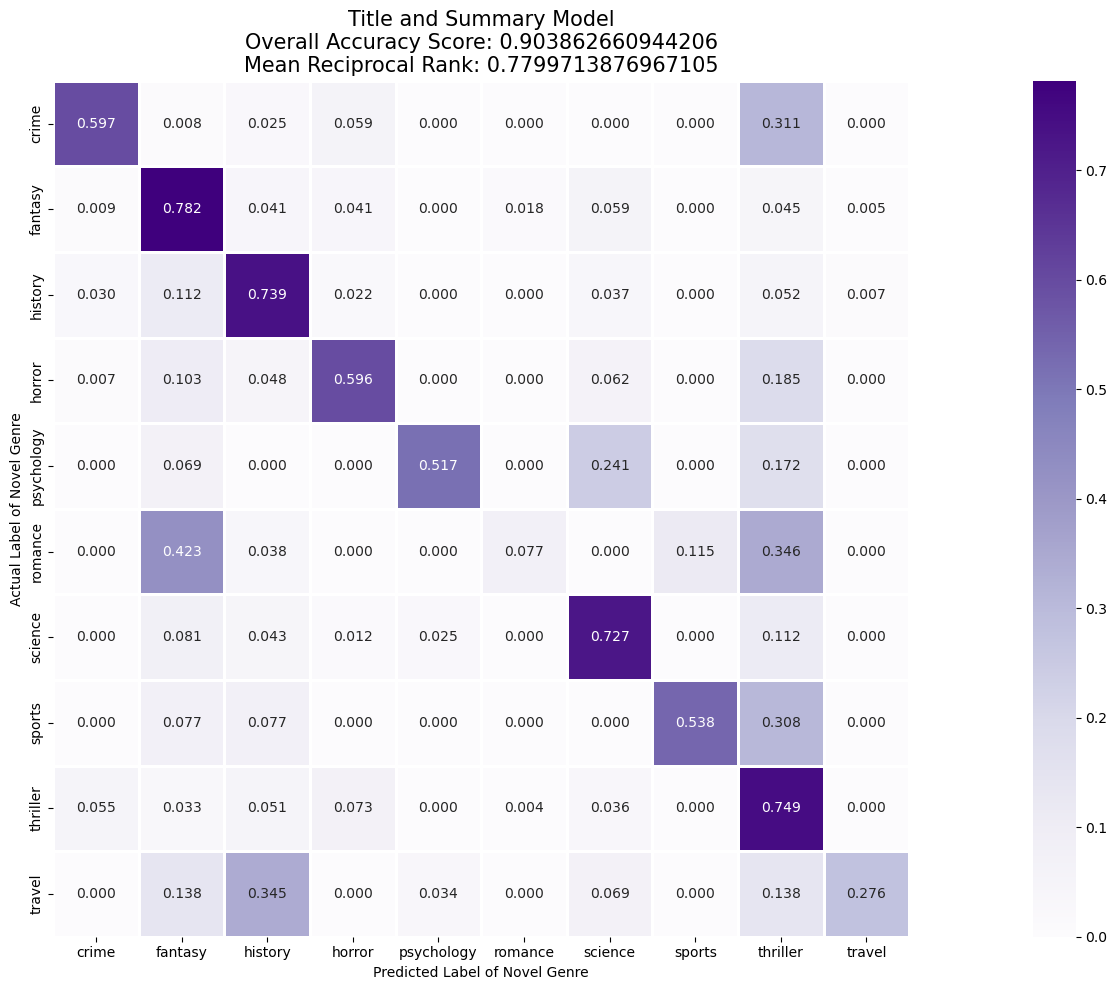

2023-12-12 18:43:55,963 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:56,141 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:56,223 : INFO : Starting evaluation...
2023-12-12 18:43:56,231 : INFO : Done training and evaluation.
2023-12-12 18:43:56,231 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:56,369 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:56,451 : INFO : Starting evaluation...
2023-12-12 18:43:56,451 : INFO : Done training and evaluation.
2023-12-12 18:43:56,451 : INFO : Extracting features and creating vocabulary...
2023-12-12 18:43:56,711 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-12 18:43:56,816 : INFO : Starting evaluation...
2023-12-12 18:43:56,816 : INFO : Done training and evaluation.
2023-12-12 18:43:56,825 : INFO : Extracting features and creating vocabulary...
2023-12-12 

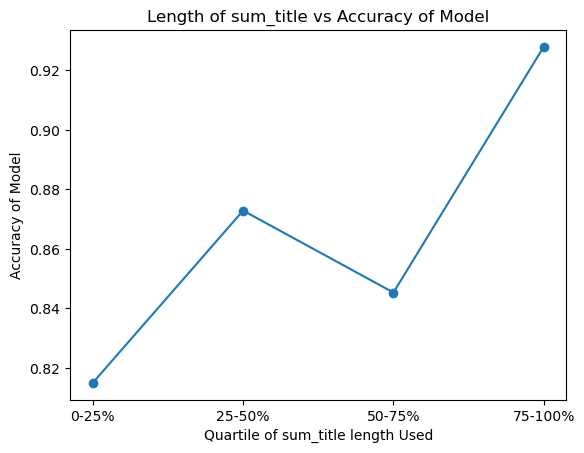

In [10]:
train_and_display('Title and Summary Model', df, 'sum_title', colors='Purples')
display_length_vs_accuracy(df, 'sum_title')

<h4>Model #3 Observations</h4>

(1) The model is slightly more accurate than model #2 with an overall accuracy of 0.9038 and a MRR of 0.7799. 

(2) Regarding a breakdown of the MRR, the model was shown to correctly categorize a novel 67.9% of the time using its highest-scoring probability, 15.62% of the time using its second highest-scoring probability, and 6.87% of the time using its third highest-scoring probability.

(3) Most of the observations for this model are consistent with model #2. However, the positive relationship between the length of the input and the accuracy of the model was weakened, specifically concerning input that fell between the top 50-75% in terms of length. We believe this to be the result of the introduced title data (which also exhibited outlier-like behavior in this specific range). As a result, we believe that - holistically - the accuracy of all 3 models will increase in accuracy with lengthier input and that there exist certain data used by our model that (for unknown reasons) performs very differently when grouped according to their length. 